This is Alia's first version of creating a Euclidean metric. There are better versions somewhere else.

This notebook is all about coming up with ways to asses how good a job PyVBMC does. 

To start, we'll state the differential equation of interest, get integration working for that equation, and run a PyVBMC optimize routine on it.


The differential equation:

$$\ddot{x} = -x -ax^b$$

generalized to deal with all values of b:

$$\ddot{x} = -x - sign(x)a|x|^b$$

$0<a\leq0.5$

 $1\leq b \leq 5$

In [1]:
import pandas as pd  # Data handling
import matplotlib.pyplot as plt # visualization
from scipy.integrate import odeint # numerical integration
import numpy as np
from pyvbmc import VBMC # VMBC object
import scipy.stats as scs # scipy stats to get distributions from
from pyvbmc.priors import UniformBox, Trapezoidal, SplineTrapezoidal, SmoothBox # nice priors from PyVBMC
from sklearn.preprocessing import StandardScaler

In [2]:
def diffyqs(X, t, a,b):
    x, vx = X[0], X[1]
    dx = vx
    dv = -x - np.sign(x) * a * np.abs(x)**b
    return [dx, dv]

initial_condition = [0.0, 3.5]
t = np.arange(0,10,0.05)

a = 0.2 
b = 4.0
sol = odeint(diffyqs, initial_condition, t, args=(a,b))

x_true = sol[:,1]

In [24]:
# s = np.random.normal(0, .1, )
y = sol[:, 1]
# print(len(y))
changed = y + np.random.normal(0, .1, 200)
solu2 = np.ndarray((200,2))
for i in range(200):
    solu2[i, 0] = sol[i, 0]
    solu2[i, 1] = changed[i]
    if i == 0:
        solu2[i, 0] = sol[i, 0]
        solu2[i, 1] = 3.5


x_true_noisy = solu2[:,1]

print(solu2)

[[ 0.          3.5       ]
 [ 0.17492706  3.48622164]
 [ 0.34941594  3.47413496]
 [ 0.52302214  3.27810826]
 [ 0.69527956  3.34109794]
 [ 0.86567531  3.43459137]
 [ 1.03361611  3.32406   ]
 [ 1.19838861  3.33899154]
 [ 1.35911685  3.07958082]
 [ 1.51472131  2.9013922 ]
 [ 1.66388527  2.86182952]
 [ 1.80503578  2.67200758]
 [ 1.9363473   2.42370754]
 [ 2.05577612  2.26022001]
 [ 2.16113157  2.01626061]
 [ 2.25018612  1.68391669]
 [ 2.3208191   1.25972928]
 [ 2.37118098  0.70632748]
 [ 2.3998569   0.23528533]
 [ 2.40600399 -0.02577999]
 [ 2.38943797 -0.41079903]
 [ 2.35065254 -1.00510376]
 [ 2.29076781 -1.27700517]
 [ 2.21141766 -1.79349636]
 [ 2.11459719 -1.94577635]
 [ 2.00249576 -2.27799576]
 [ 1.87733998 -2.52913469]
 [ 1.74126431 -2.79426923]
 [ 1.59621873 -2.97283655]
 [ 1.44391489 -3.16039361]
 [ 1.28580686 -3.33947908]
 [ 1.1230989  -3.25045177]
 [ 0.95677221 -3.37314579]
 [ 0.78762268 -3.36454124]
 [ 0.6163033  -3.29484691]
 [ 0.44336577 -3.39248484]
 [ 0.26929776 -3.61671591]
 

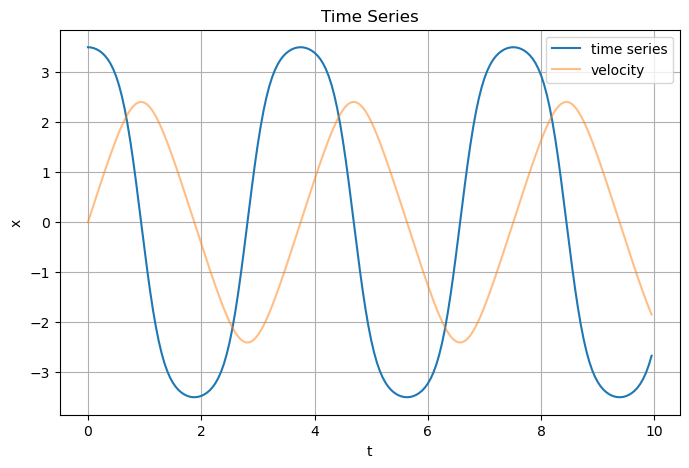

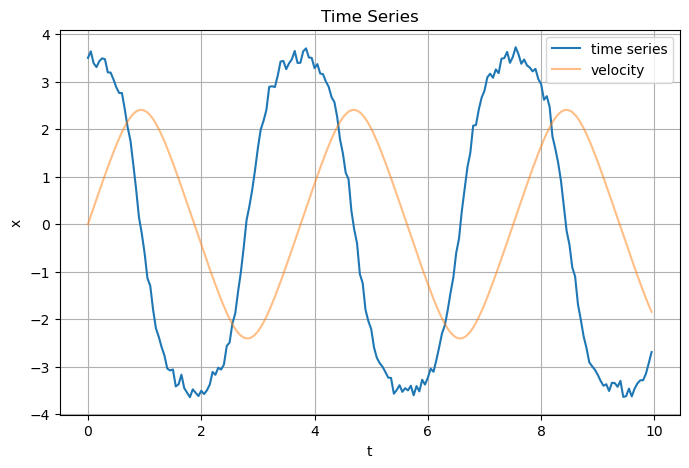

In [19]:
def plot_ts(t,ts,v, mode = 0):
    plt.figure(figsize=(8,5))
    if mode == 0:
        plt.plot(t,ts)
        plt.title('Time Series')
        plt.xlabel('t')
        plt.ylabel('x')
        plt.grid()
        plt.show()
    else:
        plt.plot(t,ts, label = 'time series')
        plt.plot(t,v, label = 'velocity', alpha = 0.5)
        plt.title('Time Series')
        plt.xlabel('t')
        plt.ylabel('x')
        plt.legend()
        plt.grid()
        plt.show()

plot_ts(t,sol[:, 1],sol[:, 0],1)
plot_ts(t, solu2[:,1], solu2[:,0],1)
# plot results
# plt.plot(t,solu2)
# plt.xlabel('time')
# plt.ylabel('x')
# plt.show()

In [31]:
def log_likelihood(theta):
    a,b = theta

    sol = odeint(diffyqs, initial_condition, t, args=(a,b)) # get solution of ODE with current choice of params
    sigma = .1
    # return -np.sum((sol[:,1] - x_true_noisy)**2) # normal distribution sorta
    return np.sum(np.log(1/(sigma* (2*np.pi)**0.5)) - (0.5/sigma**2) * (sol[:,1] - x_true_noisy)**2) # normal distribution

In [32]:
D = 2  # 2-D since there are 2 params we're estimating

LB = np.full((1, D), 0.0)  # Lower bounds
LB[0][1] = 1
UB = np.full((1, D), 0.5)  # Upper bounds
UB[0][1] = 5

PLB = np.copy(LB) + 0.1
PUB = np.copy(UB) - 0.1

x0 = np.full((1, D), 0.11) # starting point for inference   # 1.5 * np.ones((1, D))
x0[0][1] = 3.5

print(LB,PLB,PUB,UB,'x0:',x0)

[[0. 1.]] [[0.1 1.1]] [[0.4 4.9]] [[0.5 5. ]] x0: [[0.11 3.5 ]]


In [34]:
prior = SplineTrapezoidal(LB, PLB, PUB, UB)

vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior) # initialize VMBC object

In [35]:
vp, results = vbmc.optimize(); # do optimization (might take a while)

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10      -13655.39     40555.41          inf        2        inf     start warm-up
     1         15      -36517.30     27718.60      2365.71        2        inf     
     2         20      -37676.76     15110.11       669.90        2      7e+04     
     3         25         117.60         1.13     11065.88        2   3.87e+05     
     4         30         124.89         0.58        10.43        2        272     


/Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/pyvbmc/vbmc/active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 7. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)


     5         35         128.31         0.12         2.86        2       79.1     
     6         40         136.19         3.04        41.37        2   1.01e+03     
     7         45         140.13         0.02         1.78        2       55.1     
     8         50         149.46         2.50        69.88        2   1.69e+03     
     9         55         152.67         0.05         4.21        2        110     


/Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/pyvbmc/vbmc/active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 4. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)
/Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/pyvbmc/vbmc/active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 5. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)
/Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/pyvbmc/vbmc/active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 6. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)
/Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/pyvbmc/vbmc/active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 2. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=Tr

    10         60         155.22         0.05         5.02        2        127     
    11         65         162.76         3.86        65.31        2   1.58e+03     
    12         70         163.65         0.06         3.76        2       91.9     
    13         75         164.66         1.67        61.60        2   1.46e+03     


/Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/pyvbmc/vbmc/active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 0. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)


    14         80         165.64         0.15        13.13        2        313     


/Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/pyvbmc/vbmc/active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 3. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)


    15         85         164.73         0.12        12.80        2        305     
    16         90         162.83         0.19        13.28        2        320     
    17         95         165.13         0.00        18.54        2        445     
    18        100         163.63         0.01        10.24        2        246     
    19        105         165.36         0.00        15.75        2        377     trim data
    20        110         174.24         0.45     36750.73        2   8.66e+05     
    21        115          47.27         0.37       553.57        2   1.35e+04     end warm-up
    22        120         173.37         0.20       461.45        2   1.13e+04     
    23        125        -805.70        11.45       126.87        2   6.29e+03     
    24        130          91.58         0.36        36.66        3   3.86e+03     
    25        135         156.81         0.01        18.91        4        663     
    26        140         160.49         0.00         3.

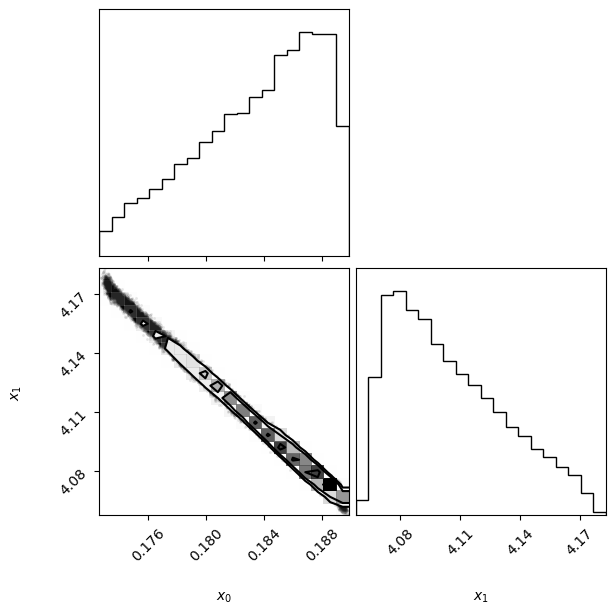

In [36]:
vp.plot();

Now that we have a Variational Posterior, we can think about defining a metric for it.

In [37]:
def euclidean_metric(vp,truth_array, n_samples = int(1e6)): 
    """
    Returns a measure of how close the actual parameters are to the estimated parameters,
    computed by finding the euclidean distance between the mean of a large sample of the 
    varaitional posterior and the true values of the parameters.

    vp: varational posterior from PyVBMC
    truth_array: numpy array of the true values of the parameters (must be in the same order as the vp returns!)
    """
    Xs, _ = vp.sample(n_samples) # sample vp
    scaler = StandardScaler(with_mean = False) # create scaler (don't bother centering)
    scaler.fit(Xs)                     # fit scaler to samples
    scaled_data = scaler.transform(Xs) # scale samples
    mean = np.array([scaled_data[:,0].mean(),scaled_data[:,1].mean()]) # compute mean of samples
    truth_scaled = scaler.transform(truth_array) # scale true data
    return np.linalg.norm(mean-truth_scaled) # return distance between mean and truth

# call the function on our current example
euclidean_metric(vp,np.array([[a,b]]))

5.429347197928944